‼️ 체크리스트

- DataLoader 설정이 최적화되어 있는지 확인할 것
- Trainer 생성 시, 체크포인트 저장 경로(root_dir)가 올바르게 설정되어 있는지 점검할 것

## 1. Import Required Packages

In [2]:
# from google.colab import drive

# drive.mount("/content/drive")

In [31]:
!pip install torchmetrics
!pip install pycocotools
!pip install faster-coco-eval
!pip install kagglehub
!pip install matplotlib
!pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [32]:
!pip -q install torchmetrics

import os
import sys
import uuid
import shutil
from collections import Counter, OrderedDict

import kagglehub

from xml.etree import ElementTree as ET

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as T

from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

from torchmetrics.detection.mean_ap import MeanAveragePrecision

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import cv2

import PIL

from tqdm.auto import tqdm


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [33]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='cuda')

In [34]:
diatom_dataset_root_dir = kagglehub.dataset_download("huseyingunduz/diatom-dataset")

diatom_images_dir = os.path.join(diatom_dataset_root_dir, "images")
diatom_xmls_dir = os.path.join(diatom_dataset_root_dir, "xmls")

## 2. Dataset Preparation

In [35]:
classes = {
  1: "Gomphonema olivaceum",
  2: "Navicula cryptotenella",
  3: "Fragilaria recapitellata",
  4: "Encyonema silesiacum",
  5: "Navicula reichardtiana",
  6: "Planothidium lanceolatum",
  7: "Gomphonema tergestinum",
  8: "Navicula cryptotenelloides",
  9: "Rhoicosphenia abbreviata",
  10: "Meridion circulare",
  11: "Surirella brebissonii var. kuetzingii",
  12: "Encyonema ventricosum",
  13: "Achnanthidium biasolettianum",
  14: "Cymbella excisa",
  15: "Diatoma moniliformis",
  16: "Cymbella cantonatii",
  17: "Diatoma mesodon",
  18: "Humidophila contenta",
  19: "Cocconeis pseudolineata",
  20: "Navicula upsaliensis",
  21: "Cymbella excisa var. subcapitata",
  22: "Halamphora veneta",
  23: "Gomphonema calcifugum",
  24: "Nitzschia linearis",
  25: "Pinnularia brebissonii",
  26: "Humidophila perpusilla",
  27: "Navicula trivialis",
  28: "Gomphonema pumilum var. rigidum",
  29: "Halamphora paraveneta",
  30: "Nitzschia hantzschiana",
  31: "Pantocsekiella ocellata",
  32: "Planothidium frequentissimum",
  33: "Adlafia minuscula",
  34: "Navicula cryptocephala",
  35: "Amphora pediculus",
  36: "Navicula tripunctata",
  37: "Navicula gregaria",
  38: "Nitzschia archibaldii",
  39: "Navicula moskalii",
  40: "Epithemia argus",
  41: "Gomphonema micropus",
  42: "Gomphonema minutum",
  43: "Navicula capitatoradiata",
  44: "Gomphonema drutelingense",
  45: "Denticula kuetzingii",
  46: "Gomphonema supertergestinum",
  47: "Achnanthidium minutissimum",
  48: "Frustulia vulgaris",
  49: "Gomphonema pumilum",
  50: "Hantzschiana abundans",
  51: "Caloneis lancettula",
  52: "Navicula novaesiberica",
  53: "Sellaphora radiosa",
  54: "Navicula lanceolata",
  55: "Gomphonema exilissimum",
  56: "Diploneis fontanella",
  57: "Luticola nivalis",
  58: "Epithemia goeppertiana",
  59: "Nitzschia recta",
  60: "Stauroneis blazenciciae",
  61: "Cymbopleura amphicephala",
  62: "Cymbella excisa var. procera",
  63: "Nitzschia palea",
  64: "Didymosphenia geminata",
  65: "Sellaphora saugerresii",
  66: "Amphora inariensis",
  67: "Neidiomorpha binodiformis",
  68: "Surella minuta"
}

class_to_idx = {v: k for k, v in classes.items()}

In [36]:
banned_xml_files = [
  "388.xml",
  "1147.xml",
  "366.xml",
  "1418.xml",
  "488.xml",
  "1256.xml",
  "475.xml",
  "1067.xml",
  "1310.xml",
  "453.xml",
  "284.xml",
  "233.xml",
  "437.xml",
]

In [37]:
def parse_xml(filepath):
  tree = ET.parse(filepath)
  root = tree.getroot()

  filename = root.find("filename").text + ".png"

  objs = []

  for obj in root.findall("objects/object"):
    class_name = obj.find("name").text

    xmin = int(obj.find("bbox/xmin").text)
    xmax = int(obj.find("bbox/xmax").text)
    ymin = int(obj.find("bbox/ymin").text)
    ymax = int(obj.find("bbox/ymax").text)

    objs.append({
      "class_name": class_name,
      "xmin": xmin,
      "xmax": xmax,
      "ymin": ymin,
      "ymax": ymax,
    })

  return {
    "filename": filename,
    "objects": objs
  }

parse_xml(os.path.join(diatom_xmls_dir, "25.xml"))

{'filename': '25.png',
 'objects': [{'class_name': 'Gomphonema drutelingense',
   'xmin': 604,
   'xmax': 874,
   'ymin': 1101,
   'ymax': 1248},
  {'class_name': 'Cymbella cantonatii',
   'xmin': 648,
   'xmax': 1227,
   'ymin': 839,
   'ymax': 1116}]}

In [38]:
class DiatomDataset(Dataset):
  def __init__(self, root_dir, classes, class_to_idx, banned_xml_files=[], transform=None, train=True):
    self.root_dir = root_dir
    self.classes = classes
    self.class_to_idx = class_to_idx
    self.transform = transform

    self.xml_dir = os.path.join(self.root_dir, "xmls")
    self.image_dir = os.path.join(self.root_dir, "images")

    self.xml_files = os.listdir(self.xml_dir)
    self.xml_files = [
      xml_file for xml_file in self.xml_files if xml_file.endswith(".xml") and xml_file not in banned_xml_files
    ]

    split_idx = int(len(self.xml_files) * 0.8)

    if train:
      self.xml_files = self.xml_files[:split_idx]
    else:
      self.xml_files = self.xml_files[split_idx:]

  def __len__(self):
    return len(self.xml_files)

  def __getitem__(self, index):
    xml = parse_xml(os.path.join(self.xml_dir, self.xml_files[index]))

    image_filename = os.path.join(self.image_dir, xml["filename"])

    image = PIL.Image.open(image_filename).convert("RGB")
    if self.transform:
      image = self.transform(image)

    boxes, labels = zip(*[
      (
        (*self._extract_bndbox(obj),), self.class_to_idx[obj["class_name"]]
      ) for obj in xml["objects"]
    ])

    target = {
      "boxes": torch.tensor(boxes, dtype=torch.float32),
      "labels": torch.tensor(labels, dtype=torch.int64),
    }

    return image, target

  def _extract_bndbox(self, obj):
    return obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]

In [39]:
train_dataset = DiatomDataset(
  diatom_dataset_root_dir,
  classes,
  class_to_idx,
  banned_xml_files,
  transform=transforms.ToTensor(),
  train=True
)

test_dataset = DiatomDataset(
  diatom_dataset_root_dir,
  classes,
  class_to_idx,
  banned_xml_files,
  transform=transforms.ToTensor(),
  train=False
)

In [40]:
train_dataloader = DataLoader(
  dataset=train_dataset,
  batch_size=4,
  shuffle=True,
  num_workers=6,
  pin_memory=True,
  prefetch_factor=4,
  collate_fn=lambda batch: tuple(zip(*batch))
)

test_dataloader = DataLoader(
  dataset=test_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=6,
  pin_memory=True,
  prefetch_factor=4,
  collate_fn=lambda batch: tuple(zip(*batch))
)

## 3. Train and Evaluation Tools

In [41]:
def to_device(images, targets):
  return [image.to(device) for image in images], [{k: v.to(device) for k, v in target.items()} for target in targets]

In [42]:
def train_epoch(dataloader, model, optimizer):
  total_loss = 0

  model.train()

  for images, targets in tqdm(dataloader, desc="Training"):
    images, targets = to_device(images, targets)

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    total_loss += losses.item()

  return total_loss / len(dataloader)

def validate_epoch(dataloader, model):
  mean_ap = MeanAveragePrecision().to(device)

  model.eval()

  with torch.no_grad():
    for images, targets in tqdm(dataloader, desc="Validating"):
      images, targets = to_device(images, targets)

      outputs = model(images)

      mean_ap.update(outputs, targets)

  score = mean_ap.compute()
  score_cpu = {k: v.cpu() if torch.is_tensor(v) else v for k, v in score.items()}

  return score

In [43]:
def plot_detection_train_log(train_losses, val_maps, val_map_50s, val_map_75s):
  epochs = np.arange(1, len(train_losses) + 1)

  plt.figure(figsize=(15, 6))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label="Train Loss", marker='o', linewidth=2)
  plt.title("Training Loss over Epochs", fontsize=14)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("Loss", fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend(fontsize=10)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, val_maps, label="mAP@[.5:.95]", marker='o', linewidth=2)
  plt.plot(epochs, val_map_50s, label="mAP@50", marker='s', linewidth=2)
  plt.plot(epochs, val_map_75s, label="mAP@75", marker='^', linewidth=2)
  plt.title("Validation mAP over Epochs", fontsize=14)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("mAP", fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend(fontsize=10)

  plt.tight_layout()
  plt.show()

In [44]:
class Trainer:
  def __init__(self, model, optimizer, train_dataloader, test_dataloader, root_dir="/workspace/checkpoints"):
    self.model = model
    self.optimizer = optimizer
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader
    self.root_dir = root_dir

    self.complete_epoch = 0

    self.train_losses = []
    self.scores = []

    self.checkouts = {}

  def train(self, epoch, is_checkout=True):
    start_epoch = self.complete_epoch + 1

    for cur_epoch in range(start_epoch, start_epoch + epoch):
      loss = train_epoch(self.train_dataloader, self.model, self.optimizer)
      score = validate_epoch(self.test_dataloader, self.model)

      print(f"Epoch: {self.complete_epoch + 1} | "
          f"Train Loss: {loss:.3f} | "
          f"Val mAP: {score['map'].item():.3f} | "
          f"Val mAP@50: {score['map_50'].item():.3f} | "
          f"Val mAP@75: {score['map_75'].item():.3f}")

      self.train_losses.append(loss)
      self.scores.append(score)

      self.complete_epoch = cur_epoch

    if is_checkout:
      self.checkout()

    self.plot_log()

  def evaluate(self):
    score = validate_epoch(self.test_dataloader, self.model)

    print(f"Val mAP: {score['map'].item():.3f} | "
          f"Val mAP@50: {score['map_50'].item():.3f} | "
          f"Val mAP@75: {score['map_75'].item():.3f}")

    self.plot_log()

    return score

  def plot_log(self):
    if not self.scores:
        print("No evaluation scores to plot yet.")
        return

    val_maps, val_map_50s, val_map_75s = zip(*[
      (score["map"].item(), score["map_50"].item(), score["map_75"].item()) for score in self.scores
    ])

    plot_detection_train_log(self.train_losses, val_maps, val_map_50s, val_map_75s)

  def checkout(self):
    if self.complete_epoch in self.checkouts:
      return

    random_id = uuid.uuid4().hex[:8]

    os.makedirs(self.root_dir, exist_ok=True)

    output_path = os.path.join(self.root_dir, f"{random_id}-epoch{self.complete_epoch}.pt")

    self.checkouts[self.complete_epoch] = output_path

    torch.save(
      {
        "model_state_dict": self.model.state_dict(),
        "optimizer_state_dict": self.optimizer.state_dict(),
        "epoch": self.complete_epoch,
      },
      output_path
    )

  def load_checkpoint(self, checkpoint):
    if checkpoint not in self.checkouts:
      print(f"Checkpoint {checkpoint} not found.", file=sys.stderr)
      return

    checkpoint_data = torch.load(self.checkouts[checkpoint])
    self.model.load_state_dict(checkpoint_data["model_state_dict"])
    self.optimizer.load_state_dict(checkpoint_data["optimizer_state_dict"])
    self.complete_epoch = checkpoint

    print(f"Checkpoint {checkpoint} loaded.")

**`Trainer` 사용 예시**

```python
>>> trainer = Trainer(model, optimizer, train_dataloader, test_dataloader)

>>> trainer.train(epoch=5, checkout=True) # 첫 5 에포크 학습
    # ... 로그, 지표, 그래프 출력

>>> trainer.train(epoch=5, checkout=True) # 추가 5 에포크 학습
    # ... 로그, 지표, 그래프 출력

>>> trainer.load_checkpoint(checkpoint=5) # 해당 체크포인트로 모델, 옵티마이저 이동

>>> trainer.evaluate()
    # ... 지표, 그래프 출력
```

## 4. Load a Pre-trained Model

In [45]:
def get_retinanet_model(num_classes):
  weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
  model = retinanet_resnet50_fpn(weights=weights)

  in_features = model.backbone.out_channels
  num_anchors = model.head.classification_head.num_anchors

  model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
  )

  return model

## 5. Finetune - Only head

In [18]:
model = get_retinanet_model(len(classes) + 1)
model.to(device)

for param in model.backbone.parameters():
    param.requires_grad = False

optimizer = torch.optim.SGD(
  [p for p in model.parameters() if p.requires_grad],
  lr=0.005,
  momentum=0.9,
)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 272MB/s] 


In [19]:
trainer = Trainer(model, optimizer, train_dataloader, test_dataloader, root_dir="/workspace/retinanet-head")

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.511 | Val mAP: 0.000 | Val mAP@50: 0.000 | Val mAP@75: 0.000


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

AssertionError    : self._shutdown_workers()can only test a child process

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 2 | Train Loss: 1.085 | Val mAP: 0.006 | Val mAP@50: 0.008 | Val mAP@75: 0.008


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch: 3 | Train Loss: 0.989 | Val mAP: 0.010 | Val mAP@50: 0.011 | Val mAP@75: 0.011


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 0.890 | Val mAP: 0.010 | Val mAP@50: 0.014 | Val mAP@75: 0.012


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>

Exception ignored in: Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__


        
Traceback (most recent call last):
Tra

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 0.765 | Val mAP: 0.022 | Val mAP@50: 0.026 | Val mAP@75: 0.025


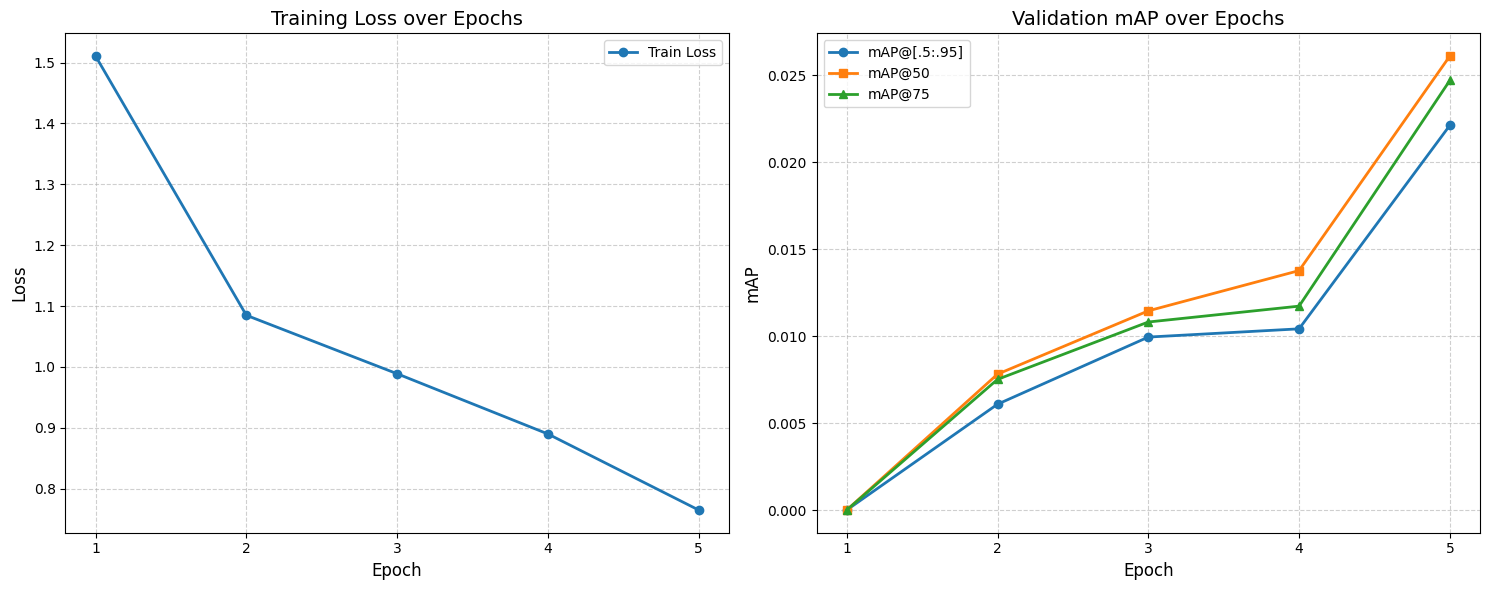

In [20]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.718 | Val mAP: 0.024 | Val mAP@50: 0.029 | Val mAP@75: 0.027


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.681 | Val mAP: 0.047 | Val mAP@50: 0.056 | Val mAP@75: 0.055


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.660 | Val mAP: 0.039 | Val mAP@50: 0.044 | Val mAP@75: 0.044


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.620 | Val mAP: 0.055 | Val mAP@50: 0.064 | Val mAP@75: 0.063


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.600 | Val mAP: 0.051 | Val mAP@50: 0.061 | Val mAP@75: 0.060


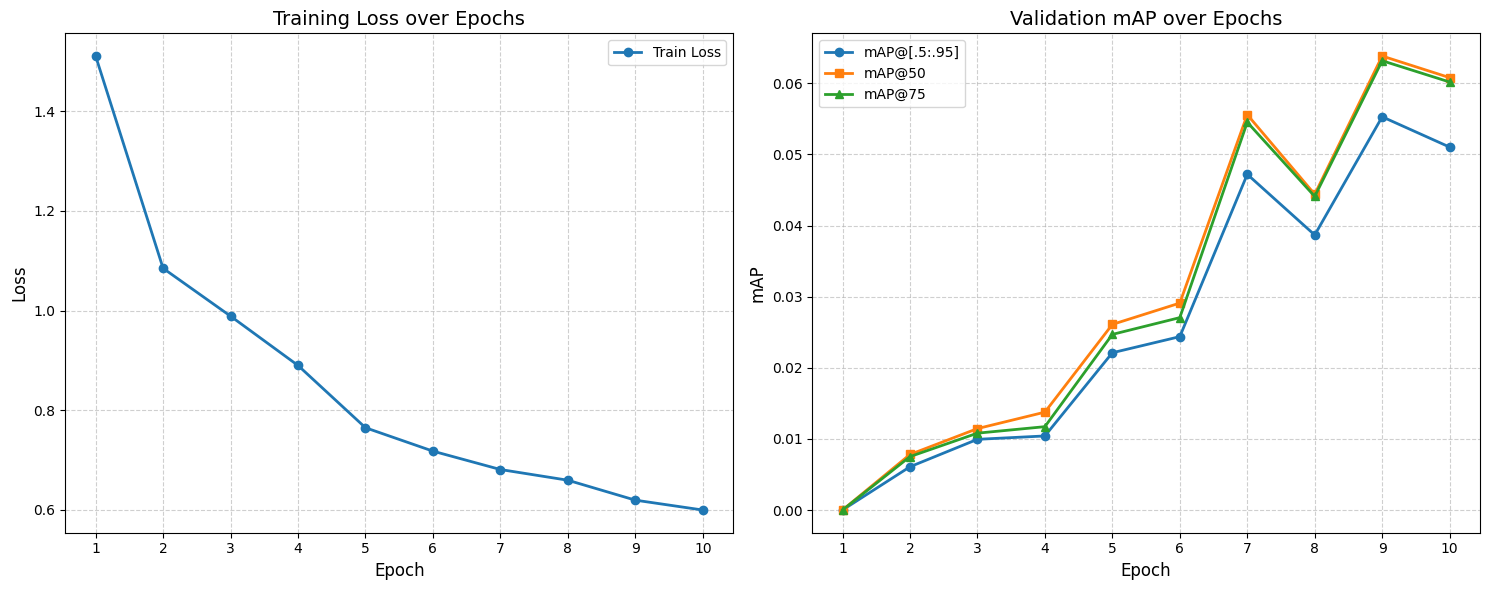

In [21]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/

Epoch: 11 | Train Loss: 0.579 | Val mAP: 0.061 | Val mAP@50: 0.071 | Val mAP@75: 0.069


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.563 | Val mAP: 0.095 | Val mAP@50: 0.109 | Val mAP@75: 0.107


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.541 | Val mAP: 0.074 | Val mAP@50: 0.085 | Val mAP@75: 0.083


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.519 | Val mAP: 0.070 | Val mAP@50: 0.082 | Val mAP@75: 0.079


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.502 | Val mAP: 0.093 | Val mAP@50: 0.108 | Val mAP@75: 0.107


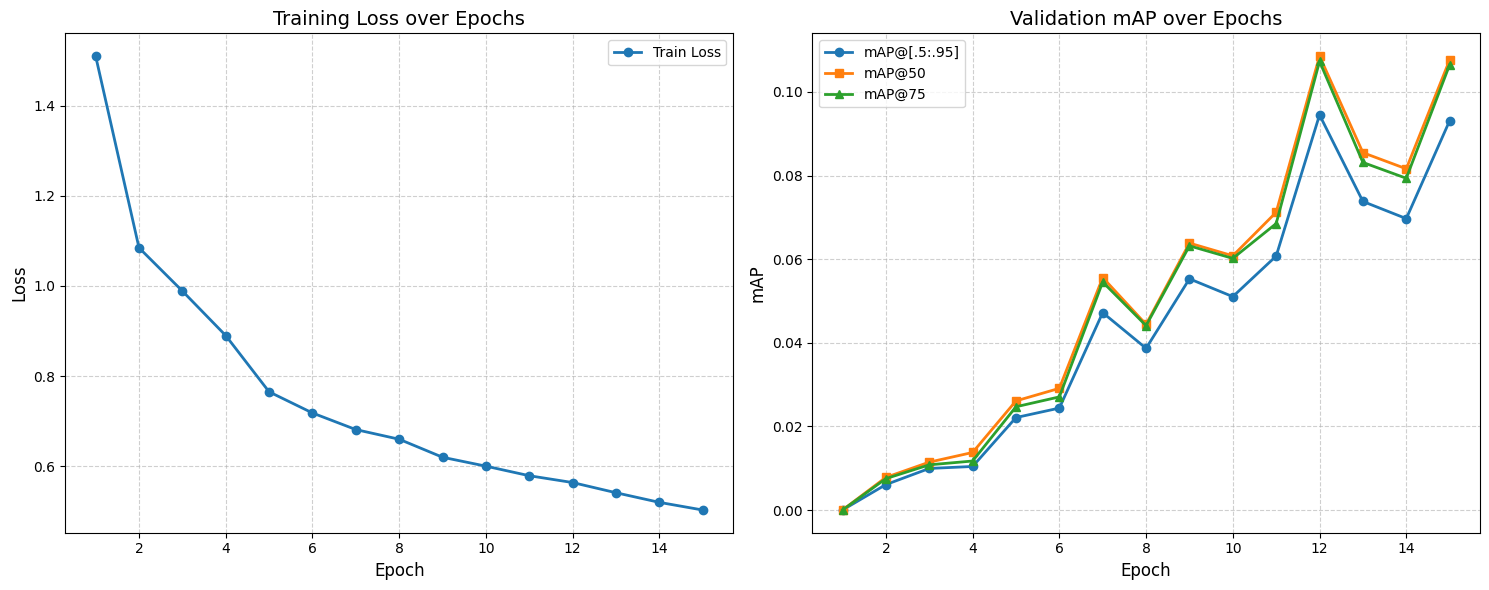

In [22]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.488 | Val mAP: 0.138 | Val mAP@50: 0.160 | Val mAP@75: 0.155


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.465 | Val mAP: 0.129 | Val mAP@50: 0.147 | Val mAP@75: 0.145


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 18 | Train Loss: 0.456 | Val mAP: 0.107 | Val mAP@50: 0.124 | Val mAP@75: 0.121


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 19 | Train Loss: 0.445 | Val mAP: 0.125 | Val mAP@50: 0.144 | Val mAP@75: 0.142


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 0.427 | Val mAP: 0.140 | Val mAP@50: 0.164 | Val mAP@75: 0.161


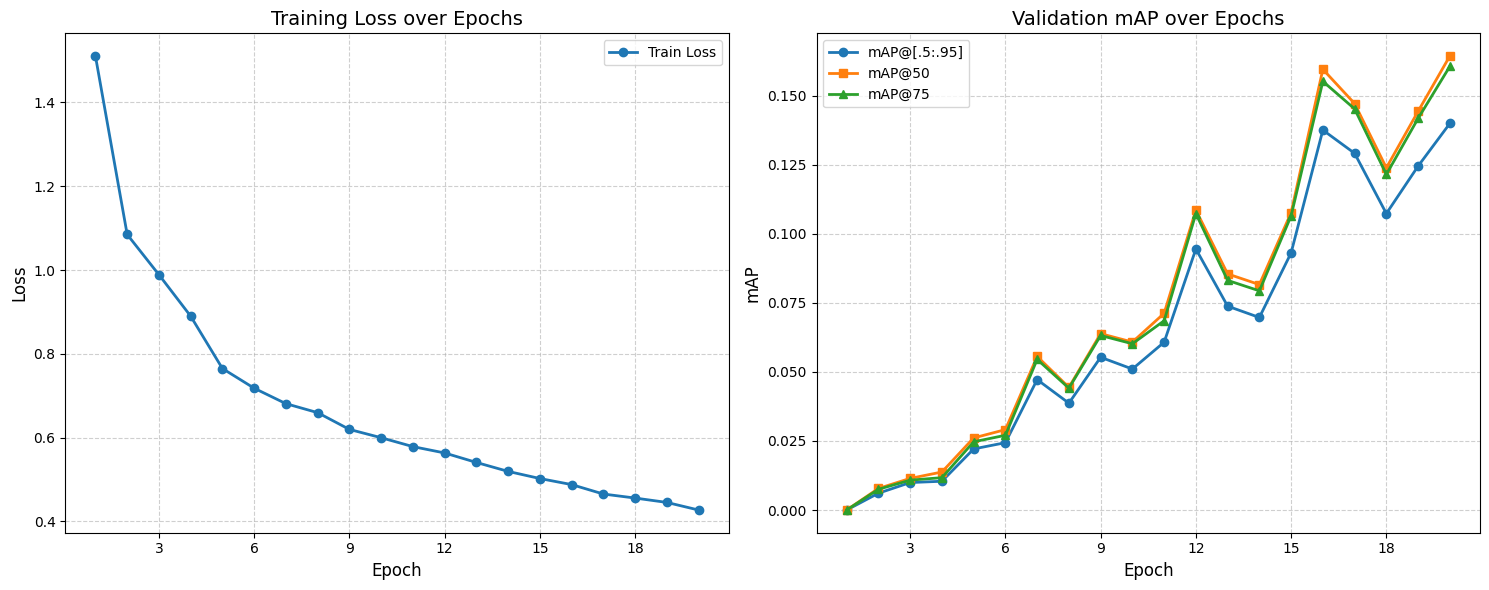

In [23]:
trainer.train(5)

## 6. Finetune - Full

**🚨 직전 실험 결과를 백업했나요?? 🚨**

In [24]:
model = get_retinanet_model(len(classes) + 1)
model.to(device)

# for param in model.backbone.parameters():
#     param.requires_grad = False

optimizer = torch.optim.SGD(
  [p for p in model.parameters() if p.requires_grad],
  lr=0.005,
  momentum=0.9,
)

In [25]:
trainer = Trainer(model, optimizer, train_dataloader, test_dataloader, root_dir="/workspace/retinanet-full")

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.454 | Val mAP: 0.000 | Val mAP@50: 0.000 | Val mAP@75: 0.000


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 1.081 | Val mAP: 0.000 | Val mAP@50: 0.000 | Val mAP@75: 0.000


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validating:   0%|          | 0/110 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: 3 | Train Loss: 0.766 | Val mAP: 0.027 | Val mAP@50: 0.033 | Val mAP@75: 0.029


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 0.681 | Val mAP: 0.042 | Val mAP@50: 0.049 | Val mAP@75: 0.047


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 0.632 | Val mAP: 0.024 | Val mAP@50: 0.028 | Val mAP@75: 0.027


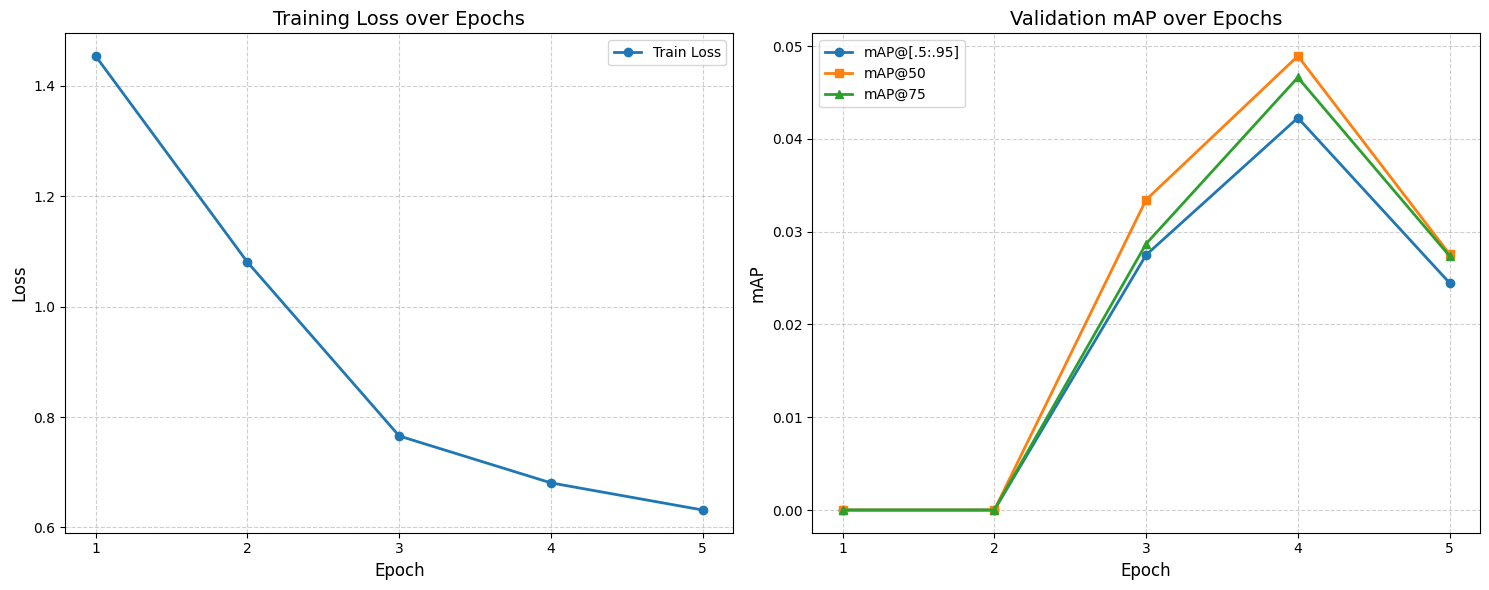

In [26]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.583 | Val mAP: 0.063 | Val mAP@50: 0.072 | Val mAP@75: 0.072


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.528 | Val mAP: 0.097 | Val mAP@50: 0.111 | Val mAP@75: 0.110


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.499 | Val mAP: 0.100 | Val mAP@50: 0.112 | Val mAP@75: 0.111


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.473 | Val mAP: 0.145 | Val mAP@50: 0.162 | Val mAP@75: 0.159


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.437 | Val mAP: 0.160 | Val mAP@50: 0.178 | Val mAP@75: 0.170


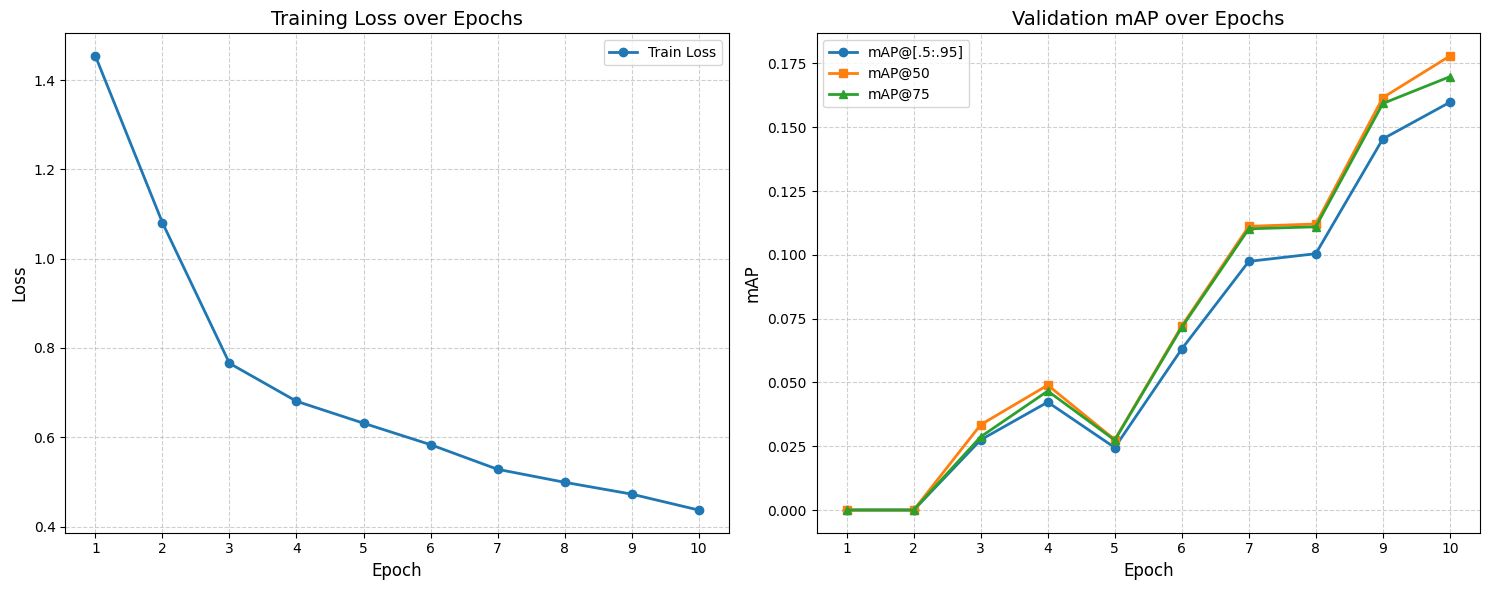

In [27]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 11 | Train Loss: 0.419 | Val mAP: 0.190 | Val mAP@50: 0.208 | Val mAP@75: 0.201


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>

AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 12 | Train Loss: 0.390 | Val mAP: 0.229 | Val mAP@50: 0.253 | Val mAP@75: 0.250


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.346 | Val mAP: 0.263 | Val mAP@50: 0.289 | Val mAP@75: 0.288


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.307 | Val mAP: 0.299 | Val mAP@50: 0.328 | Val mAP@75: 0.326


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.292 | Val mAP: 0.287 | Val mAP@50: 0.318 | Val mAP@75: 0.314


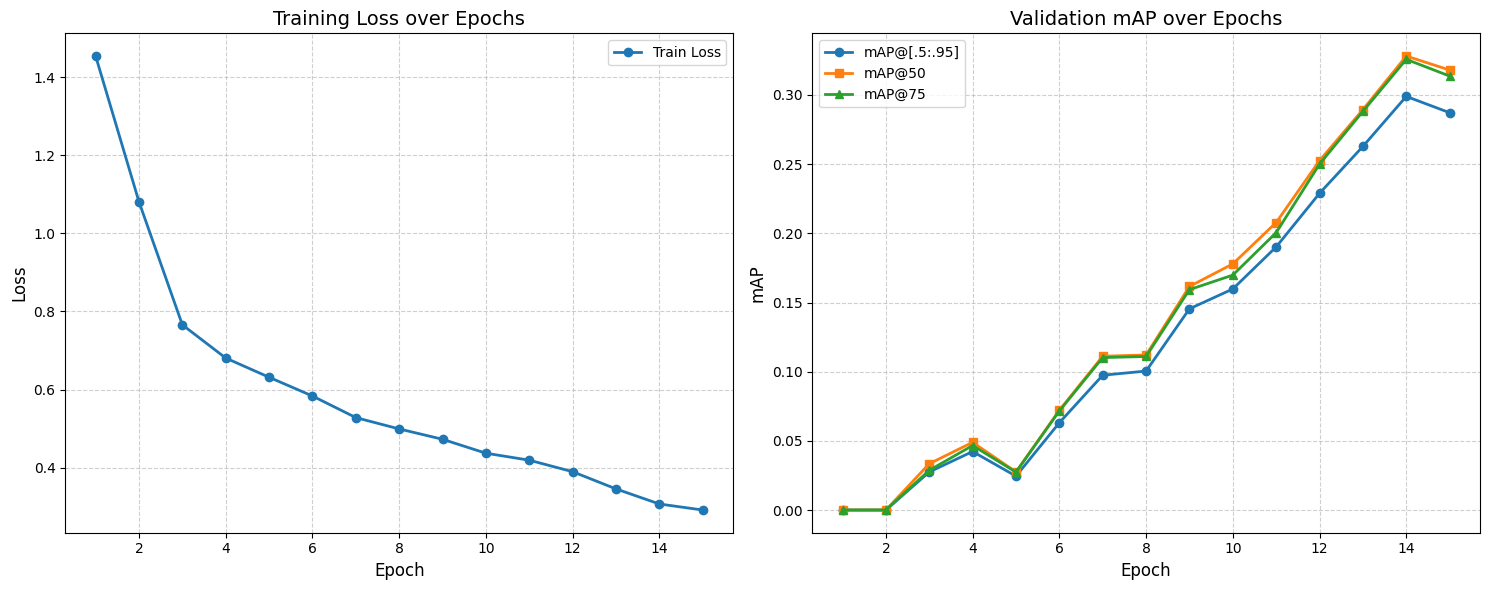

In [28]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.282 | Val mAP: 0.306 | Val mAP@50: 0.342 | Val mAP@75: 0.337


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.276 | Val mAP: 0.326 | Val mAP@50: 0.356 | Val mAP@75: 0.355


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.241 | Val mAP: 0.270 | Val mAP@50: 0.290 | Val mAP@75: 0.289


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 0.247 | Val mAP: 0.344 | Val mAP@50: 0.388 | Val mAP@75: 0.383


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 0.211 | Val mAP: 0.391 | Val mAP@50: 0.424 | Val mAP@75: 0.418


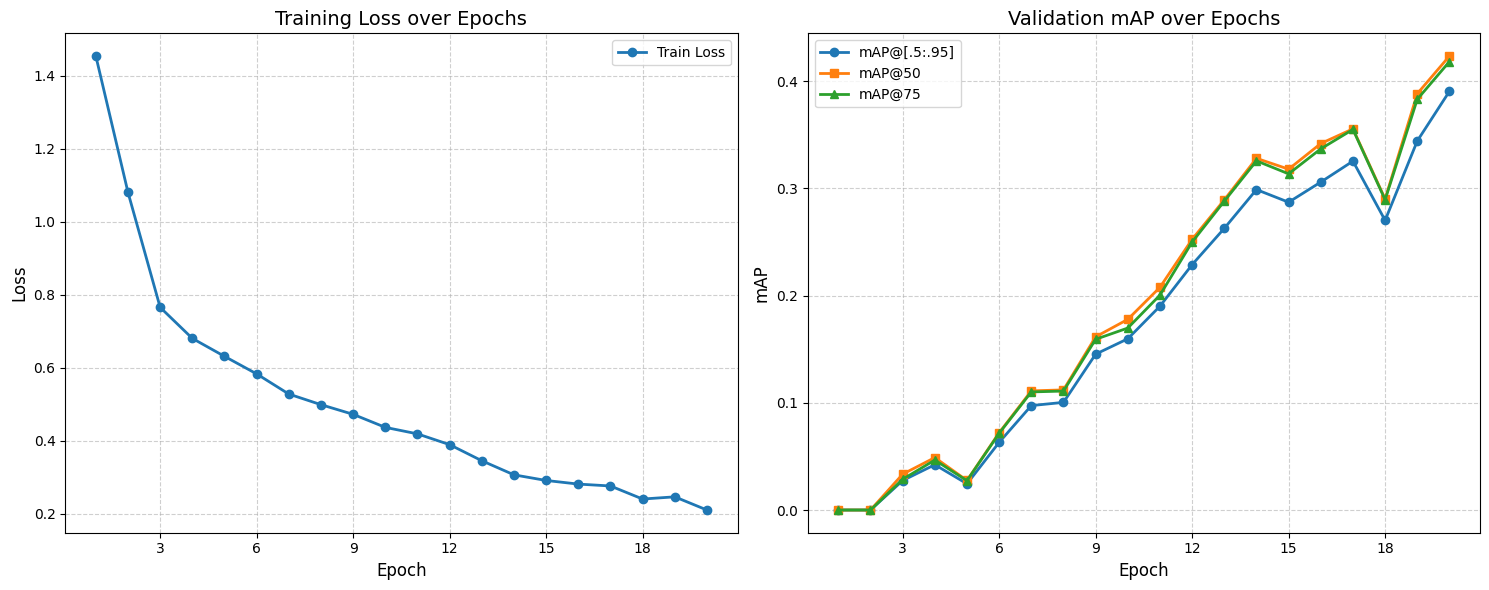

In [29]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 0.199 | Val mAP: 0.379 | Val mAP@50: 0.413 | Val mAP@75: 0.411


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 0.182 | Val mAP: 0.351 | Val mAP@50: 0.379 | Val mAP@75: 0.376


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 0.171 | Val mAP: 0.386 | Val mAP@50: 0.414 | Val mAP@75: 0.411


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 0.145 | Val mAP: 0.377 | Val mAP@50: 0.416 | Val mAP@75: 0.412


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 0.130 | Val mAP: 0.413 | Val mAP@50: 0.446 | Val mAP@75: 0.443


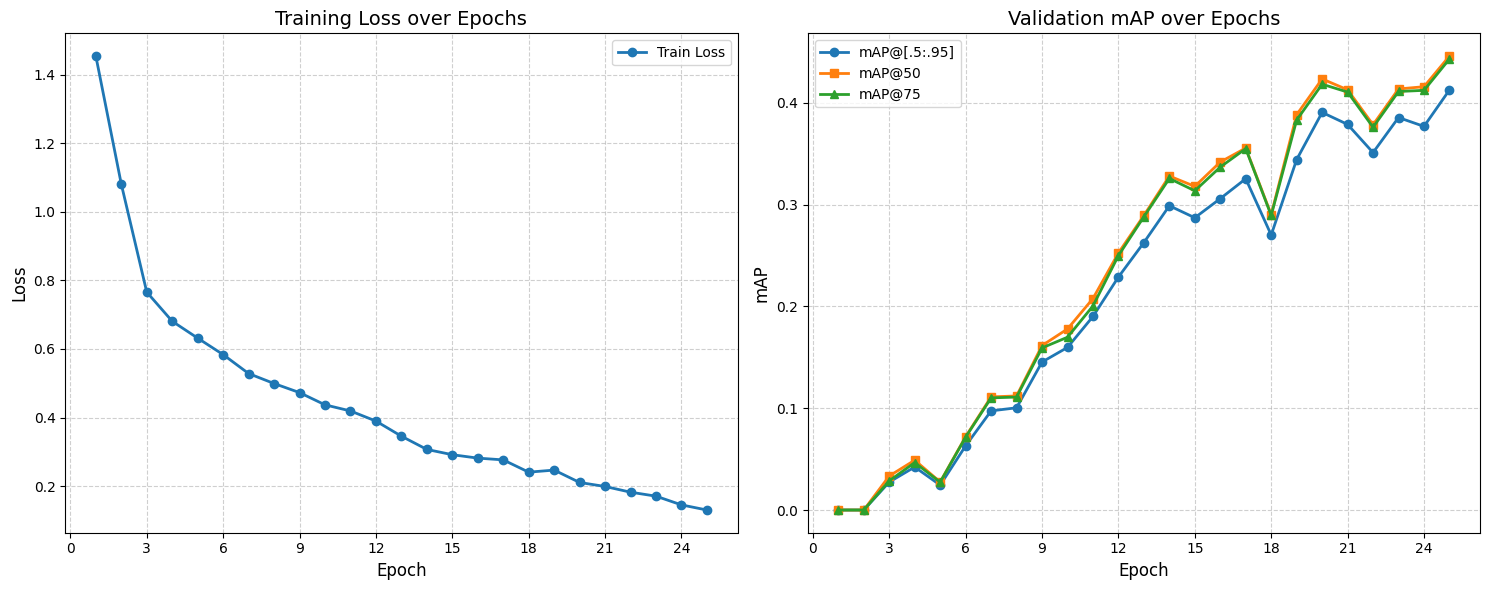

In [30]:
trainer.train(5)

## 7. Finetune - Backbone(lr=1e-4), Head(lr=1e-2)

**🚨 직전 실험 결과를 백업했나요?? 🚨**

In [47]:
model = get_retinanet_model(len(classes) + 1)
model.to(device)

backbone_params = []
head_params = []

for name, param in model.named_parameters():
  if not param.requires_grad:
    continue
  if name.startswith("backbone"):
    backbone_params.append(param)
  elif name.startswith("head"):
    head_params.append(param)

optimizer = torch.optim.SGD(
  [
    {"params": backbone_params, "lr": 1e-4},
    {"params": head_params, "lr": 1e-2},
  ],
  momentum=0.9
)

In [48]:
trainer = Trainer(model, optimizer, train_dataloader, test_dataloader, root_dir="/workspace/retinanet-mix-1")

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.365 | Val mAP: 0.000 | Val mAP@50: 0.000 | Val mAP@75: 0.000


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 0.989 | Val mAP: 0.015 | Val mAP@50: 0.018 | Val mAP@75: 0.016


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 0.773 | Val mAP: 0.018 | Val mAP@50: 0.022 | Val mAP@75: 0.019


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validating:   0%|          | 0/110 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 4 | Train Loss: 0.689 | Val mAP: 0.028 | Val mAP@50: 0.032 | Val mAP@75: 0.031


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 0.651 | Val mAP: 0.040 | Val mAP@50: 0.045 | Val mAP@75: 0.044


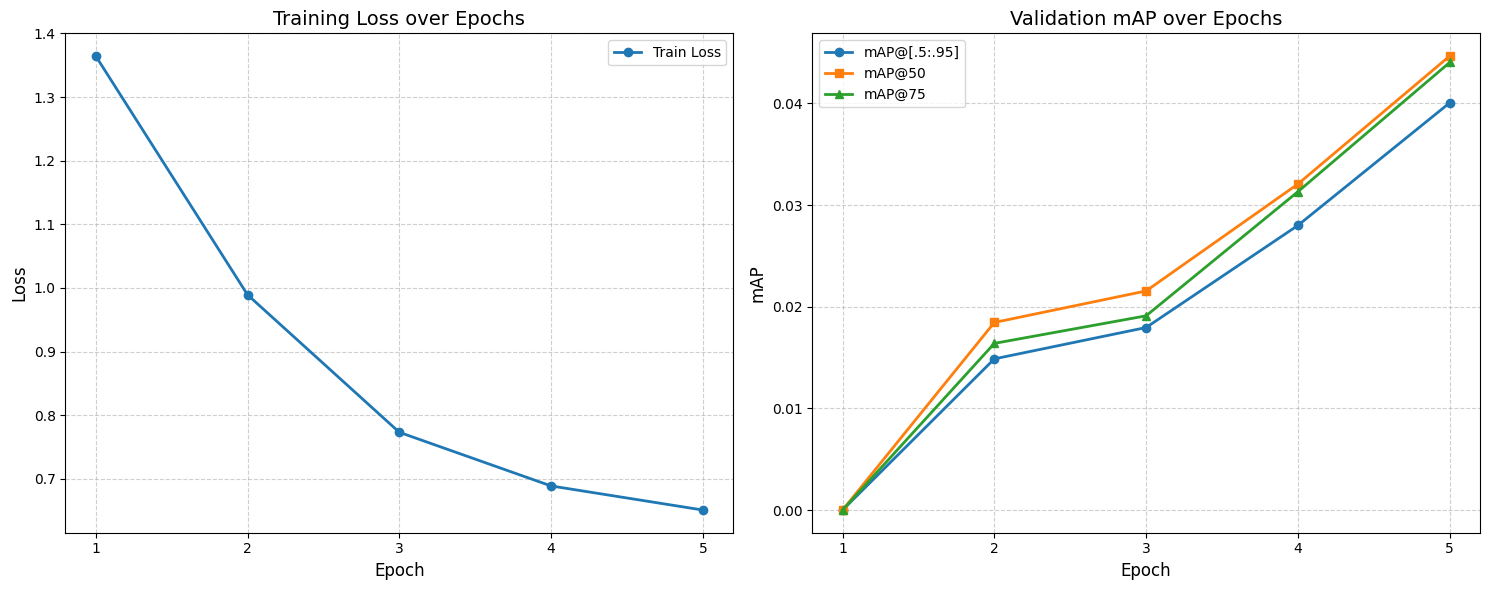

In [49]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 6 | Train Loss: 0.604 | Val mAP: 0.053 | Val mAP@50: 0.058 | Val mAP@75: 0.058


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.570 | Val mAP: 0.069 | Val mAP@50: 0.079 | Val mAP@75: 0.076


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.544 | Val mAP: 0.079 | Val mAP@50: 0.089 | Val mAP@75: 0.088


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.515 | Val mAP: 0.108 | Val mAP@50: 0.127 | Val mAP@75: 0.126


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.480 | Val mAP: 0.124 | Val mAP@50: 0.140 | Val mAP@75: 0.140


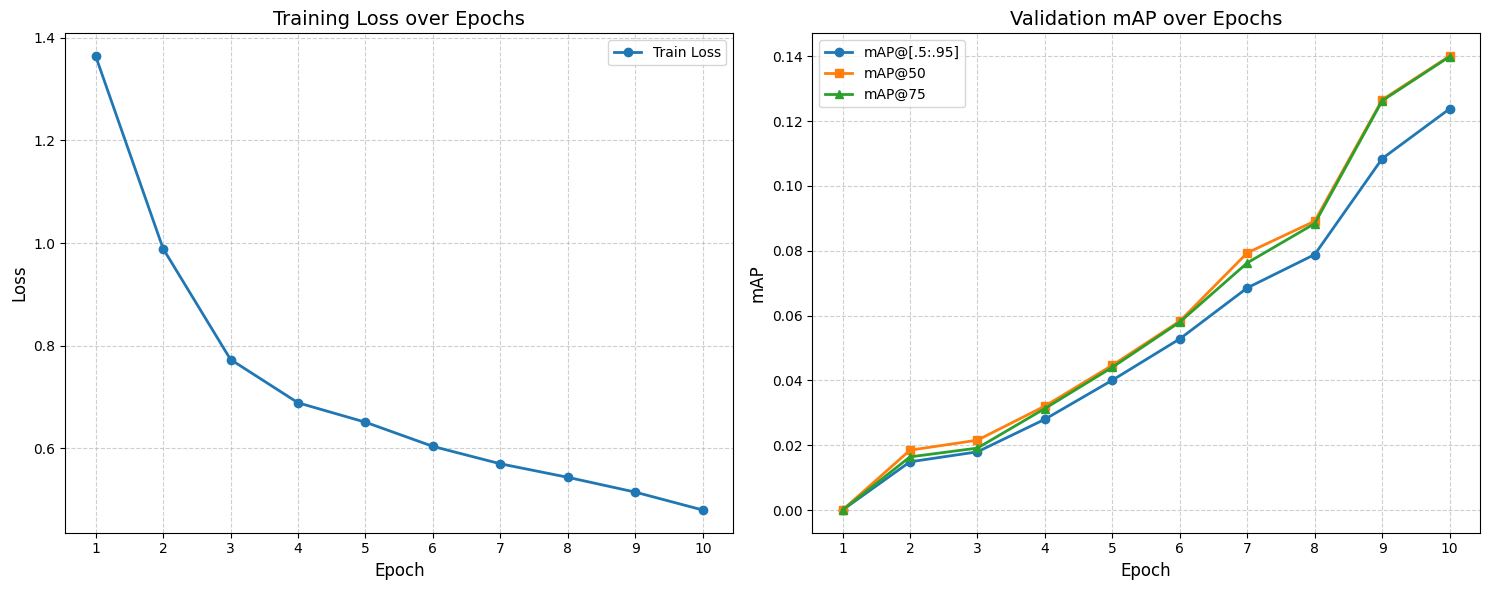

In [50]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 0.459 | Val mAP: 0.169 | Val mAP@50: 0.192 | Val mAP@75: 0.191


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.428 | Val mAP: 0.173 | Val mAP@50: 0.195 | Val mAP@75: 0.195


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 13 | Train Loss: 0.396 | Val mAP: 0.173 | Val mAP@50: 0.195 | Val mAP@75: 0.192


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.370 | Val mAP: 0.170 | Val mAP@50: 0.191 | Val mAP@75: 0.190


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.350 | Val mAP: 0.207 | Val mAP@50: 0.233 | Val mAP@75: 0.232


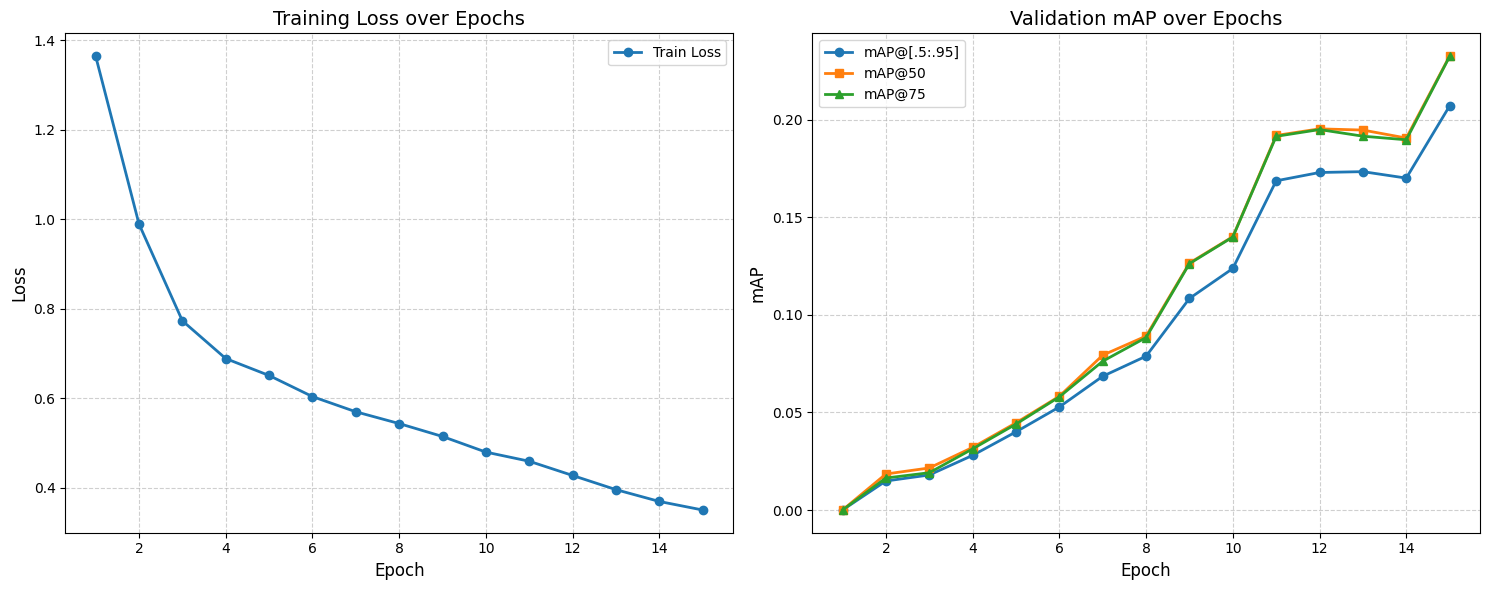

In [51]:
trainer.train(5)

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.325 | Val mAP: 0.211 | Val mAP@50: 0.238 | Val mAP@75: 0.234


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 17 | Train Loss: 0.300 | Val mAP: 0.257 | Val mAP@50: 0.282 | Val mAP@75: 0.282


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.288 | Val mAP: 0.234 | Val mAP@50: 0.261 | Val mAP@75: 0.258


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 19 | Train Loss: 0.261 | Val mAP: 0.315 | Val mAP@50: 0.357 | Val mAP@75: 0.352


Training:   0%|          | 0/437 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a283e7ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 20 | Train Loss: 0.245 | Val mAP: 0.259 | Val mAP@50: 0.299 | Val mAP@75: 0.295


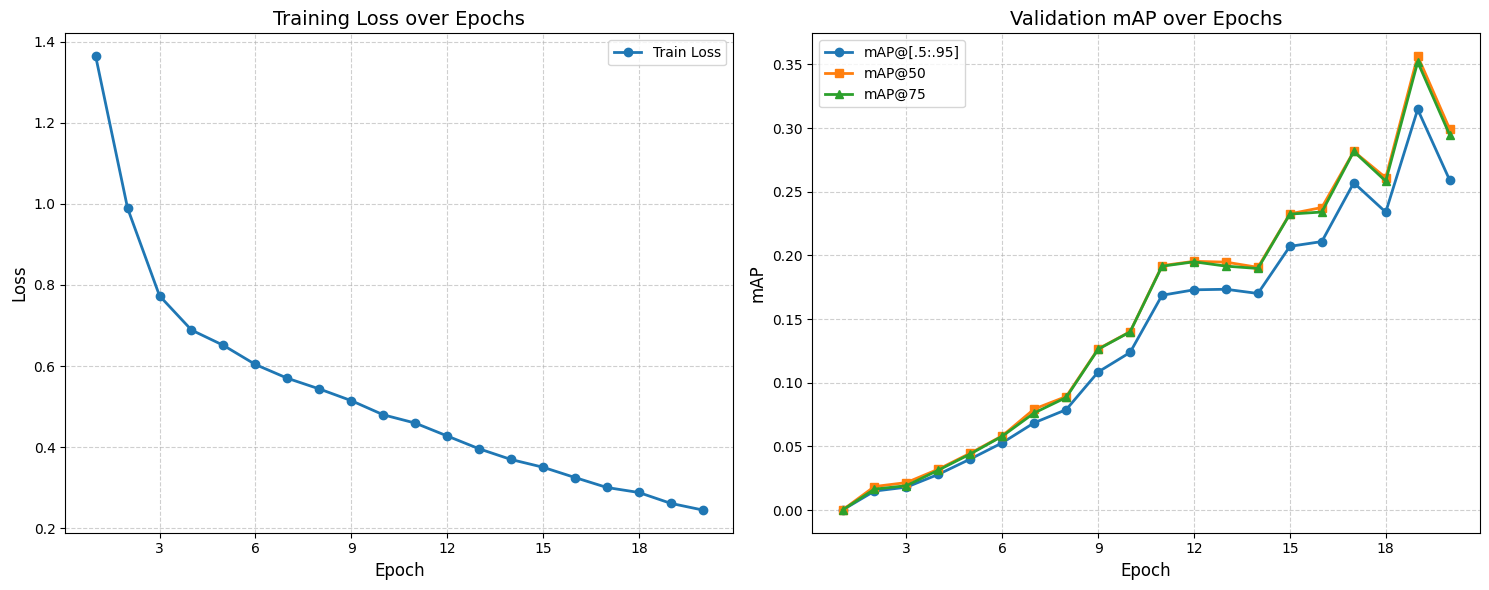

In [52]:
trainer.train(5)